# Empirical evaluation using real data

Whilst simulating data offers unparalleled control of testing conditions, it carries with it the risk that the synthetic data generation procedure is not representative of the generative procedures underlying the real-world datasets on which the models are applied in practice. As such, a means by which to complement simulation based approaches with evaluation of model performance on real datasets is highly desirable. Unfortunately, because of the fundamental problem of causal inference, we may never observe a true counterfactual against which to compare our models. To overcome this limitation, I propose to fit models to units where the estimated quantity is the observed potential outcome, namely control units. Specifically, we isolate one control unit in a dataset used for SC, pretend it was subjected to a treatment at some time T0, and fit a synthetic control unit to it using the remaining control units as the donor pool. Because the control unit never received the treatment, the true treatment effect is zero. Consequently, we can compare models based on how close, as measured using RMSPE, the synthetic control units are to the observed post-treatment outcome. We repeat this procedure for every control unit across several datasets from published studies applying synthetic control methodology, such that the assumptions of the model hold for the units in the dataset, and report the pre-treatment RMSPE, the post-treatment RMSPE, and the pre/post-treatment RMSPE ratio for the SC, SDID and DSC.

N.B.: Remaining subsections under this section are unfinished

In [30]:
import pandas as pd
import numpy as np
from SyntheticControlMethods import Synth, DiffSynth
import pandas_profiling as pp
import matplotlib.pyplot as plt

In [276]:
def compare_and_save(storage_df, dataset_loc, 
                     outcome_var, id_var, time_var,
                     treatment_period, treated_unit,
                     n_optim=10, ignore_cols = None):
    '''
    Approach:
    1. Take a dataset, drop the treated unit
    2. For each control unit:
        1. Fit Synthetic control using other control units as donor pool, record RMSPE
        2. Same but with Differenced Synthetic Control
    3. Repeat above for all datasets
    '''
    
    #Get models
    models = [Synth, DiffSynth]
    model_names = ["SC", "DSC"]
    
    #Get data
    data_dir = "https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/master/examples/datasets/"
    df = pd.read_csv(data_dir + dataset_loc + ".csv")
    df = df.loc[df[id_var] != treated_unit] #Drop treated_unit
    
    #Extract names of all control units
    units = df[id_var].unique()
    for unit in units: #For every control unit
        for model_name, model in zip(model_names, models): #For both SC and DSC
            
            if model_name == "SC":
                #Fit SC
                synth = model(df, outcome_var, id_var, time_var, treatment_period, unit, n_optim=n_optim)
                #Save results
                storage_df = store(storage_df, dataset_loc, unit, model_name, synth, constant=False)
                
            else: #if model is DiffSynth
                #Fit DSC
                synth = model(df, outcome_var, id_var, time_var, treatment_period, unit, 
                              ignore_cols=ignore_cols, n_optim=n_optim)
                #Save results
                storage_df = store(storage_df, dataset_loc, unit, model_name, synth, constant=True)
    
    #Store as csv
    storage_df.to_csv("empirical_model_comparison.csv", index=False, header=True)
    #storage_df.to_parquet("empirical_model_comparison.csv", index=False)
    return storage_df
    
    
def store(storage_df, dataset, unit, model, synth, constant):
    '''Extract relevant model metrics and save to storage_df'''
    #For convience
    data = synth.original_data
    #Make df with one observation
    synth_df = pd.DataFrame({"Dataset": [dataset],
                              "Control Unit": [unit],
                              "Method": [model],
                              "Pre RMSPE": [float(data.rmspe_df["pre_rmspe"])],
                              "Post RMSPE": [float(data.rmspe_df["post_rmspe"])],
                              "Post/pre RMSPE ratio": [float(data.rmspe_df["post/pre"])],
                              "W": [data.w],
                              "Constant": [None if model == "SC" else data.synth_constant]})
    
    #Return storage_df with new observation appended to end
    return pd.concat([storage_df, synth_df], axis=0)

## Run for all datasets

In [277]:
storage_df = pd.DataFrame({"Dataset": [],
                              "Control Unit": [],
                              "Method": [],
                              "Pre RMSPE": [],
                              "Post RMSPE": [],
                              "Post/pre RMSPE ratio": [],
                              "W":[],
                              "Constant":[]})

In [278]:
storage_df = compare_and_save(storage_df, "smoking_data",
                 "cigsale", "state", "year", 1989, "California", 10)

In [279]:
storage_df = compare_and_save(storage_df, "german_reunification", 
                 "gdp", "country", "year", 1990, "West Germany", 
                 10, ["schooling", "invest60", "invest70", "invest80"])

# Analyze Results

dimensions to analyse:
1. Pre/post ratio
2. Sparsity of w
3. pre
4. post

Ideas: make violin plot that somehow shows pre,post and ratio for the groups in one

In [281]:
storage_df.head(10)

,Dataset,Control Unit,Method,Pre RMSPE,Post RMSPE,Post/pre RMSPE ratio,W,Constant
0,smoking_data,Alabama,SC,3.965645,5.956666,1.502067,"[[0.38025488848883454], [0.004165472434911936]...",None
0,smoking_data,Alabama,DSC,4.279074,6.283651,1.468461,"[[0.3360327458842858], [0.0009772583611889504]...",2.15009
0,smoking_data,Arkansas,SC,7.120046,8.945273,1.256350,"[[0.11936930482620532], [4.4710621405929314e-0...",None
0,smoking_data,Arkansas,DSC,6.750812,8.004311,1.185681,"[[0.1439317221935714], [2.943514591988524e-14]...",5.61507
0,smoking_data,Colorado,SC,7.369287,11.764764,1.596459,"[[0.0], [3.1905894841445567e-06], [0.041372941...",None
0,smoking_data,Colorado,DSC,5.421089,6.380664,1.177008,"[[0.0], [0.0001626029228510649], [0.0063896554...",-10.92
0,smoking_data,Connecticut,SC,5.849831,5.618941,0.960530,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",None
0,smoking_data,Connecticut,DSC,5.031779,4.519762,0.898243,"[[6.867459134129966e-17], [8.344884910980312e-...",8.70503
0,smoking_data,Delaware,SC,11.348322,31.870393,2.808379,"[[0.006091967685261055], [0.006327293745788919...",None
0,smoking_data,Delaware,DSC,6.738533,11.512911,1.708519,"[[0.01782207468762007], [0.00812277369588024],...",36.2903


In [329]:
storage_df.groupby("Method")[["Pre RMSPE", "Post RMSPE"]].median()

,Pre RMSPE,Post RMSPE
Method,,
DSC,6.828512,15.347943
SC,9.805338,18.155258


In [305]:
storage_df.groupby("Method")["Post RMSPE"].describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
DSC,54.0,561.427819,1115.915281,1.306473,7.590868,15.347943,740.902530,5303.768744
SC,54.0,587.630018,1197.787884,1.467441,8.953373,18.155258,751.938358,5229.718321


In [306]:
storage_df.groupby("Method")["Pre RMSPE"].describe()

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
DSC,54.0,117.167535,237.595254,2.130295,4.280585,6.828512,130.765594,1195.28902
SC,54.0,157.876590,372.978534,2.792466,5.946089,9.805338,119.008771,1772.21183


## Segregating by Dataset too

In [331]:
storage_df.groupby(["Dataset","Method"])["Pre RMSPE"].describe()

count        mean         std        min  \
Dataset              Method                                             
german_reunification DSC      16.0  380.412459  307.210567  95.551032   
                     SC       16.0  505.679761  554.708520  90.542097   
smoking_data         DSC      38.0    6.327567    4.157620   2.130295   
                     SC       38.0   11.433149   13.810057   2.792466   

                                    25%         50%         75%          max  
Dataset              Method                                                   
german_reunification DSC     178.694113  263.957721  433.561071  1195.289020  
                     SC      150.131622  245.470983  551.193395  1772.211830  
smoking_data         DSC       3.470067    5.070766    7.227003    20.053207  
                     SC        4.978909    7.320021   10.796258    71.434098

In [332]:
storage_df.groupby(["Dataset","Method"])["Post RMSPE"].describe()

count         mean          std         min  \
Dataset              Method                                                
german_reunification DSC      16.0  1866.097543  1348.947300  445.099195   
                     SC       16.0  1947.799225  1504.838478  229.432358   
smoking_data         DSC      38.0    12.093199     8.138681    1.306473   
                     SC       38.0    14.927194    13.014822    1.467441   

                                     25%          50%          75%  \
Dataset              Method                                          
german_reunification DSC     1082.694980  1443.166814  2466.811766   
                     SC       997.341198  1529.968210  2203.578682   
smoking_data         DSC        6.438274    11.103104    16.293971   
                     SC         5.970000    11.200752    18.489174   

                                     max  
Dataset              Method               
german_reunification DSC     5303.768744  
                     SC      5229.718321  
smoking_data         DSC       37.119659  
                     SC        51.600598

## Visualizing it

(Best visualization in still TBD, so far tables are most convincing IMO)

In [ ]:
#Make seperate DFs
sc_df = storage_df.loc[storage_df["Method"]=="SC"]
dsc_df = storage_df.loc[storage_df["Method"]=="DSC"]

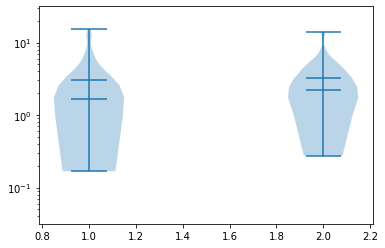

In [295]:
import seaborn as sns

data = [, storage_df.loc[storage_df["Method"]=="DSC"]["Post/pre RMSPE ratio"]]

plt.violinplot(data, [1, 2], points=20, widths=0.3,
                      showmeans=True, showextrema=True, showmedians=True)
plt.yscale('log')
plt.ylim(10**(-1.5), 10**1.5)
plt.show()

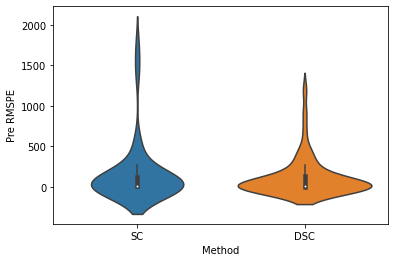

In [300]:
sns.violinplot(x='Method', y='Pre RMSPE', data=storage_df, order=[ "SC", "DSC"])
plt.show()

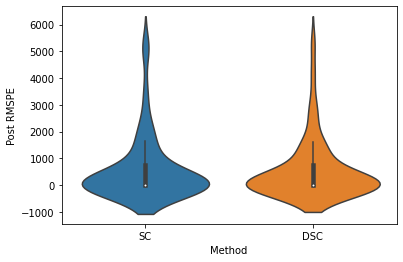

In [301]:
sns.violinplot(x='Method', y='Post RMSPE', data=storage_df, order=[ "SC", "DSC"])
plt.show()

### SC is slightly more sparse

In [326]:
def proportion_of_zero_weights(W):
    return np.count_nonzero(W==0)/len(W)

dsc_df["W"].apply(proportion_of_zero_weights).mean(), sc_df["W"].apply(proportion_of_zero_weights).mean()

(0.24791458124791454, 0.2957290623957291)